In [9]:
# Update PATH environment variable
import os
os.environ['PATH'] = '/opt/homebrew/bin:' + os.environ['PATH']

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

# To do an cumulative sum from conditionally averaged data
import itertools

from fppanalysis.running_moments import window_radius, run_norm_ds, run_mean_ds
from fppanalysis import conditional_averaging

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full, get_dt

### This code plots the vertical blob size using the cross conditional average method
#### NB: To run this code, need to be on branch 'vertical_blob_size' in fppanalysis for using conditional averaging

In [2]:
def find_fwhm_elements(array):
    """Function """
    # Convert the input to a NumPy array for efficient computation
    array_np = np.array(array)

    # Set dead pixels to zero
    array_np = np.nan_to_num(array_np)

    # Find the peak value and its index
    peak_index = np.argmax(array_np)
    peak_value = array_np[peak_index]
    half_max = peak_value / 2

    # Initialize indices for searching
    left_index = peak_index
    right_index = peak_index

    # Search to the left of the peak
    while left_index > 0 and array_np[left_index] > half_max:
        left_index -= 1
    # Adjust the left_index back to the point closest to the half_max
    if left_index > 0:
        left_index = left_index if abs(array_np[left_index] - half_max) < abs(array_np[left_index + 1] - half_max) else left_index + 1

    # Search to the right of the peak
    while right_index < len(array_np) - 1 and array_np[right_index] > half_max:
        right_index += 1
    # Adjust the right_index back to the point closest to the half_max
    if right_index < len(array_np) - 1:
        right_index = right_index if abs(array_np[right_index] - half_max) < abs(array_np[right_index - 1] - half_max) else right_index - 1

    return array_np[left_index], array_np[right_index], left_index, right_index

def vertical_blob_size(shot, init_x_pixel, init_y_pixel, num_tpts=None):

    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
    ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')

    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    f_GW = greenwald_fraction[shot]
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]

    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    R_coordinates, Z_coordinates = get_rz_full(ds)

    # Reference pixel
    data = get_signal(x=init_x_pixel, y=init_y_pixel, ds=ds)
    time = get_time(x=init_x_pixel, y=init_y_pixel, ds=ds)
    dt = get_dt(ds)

    # Vertical neighbour up
    data_up = get_signal(x=init_x_pixel, y=init_y_pixel+1, ds=ds)
    time_up = get_time(x=init_x_pixel, y=init_y_pixel+1, ds=ds)

    # Vertical neighbour down
    data_down = get_signal(x=init_x_pixel, y=init_y_pixel-1, ds=ds)
    time_down = get_time(x=init_x_pixel, y=init_y_pixel-1, ds=ds)

    Svals, _, _, _, peaks, peaks_time_base, _ = conditional_averaging.cond_av(
        data,
        time,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )
    Svals_up, _, _, _, peaks_up, peaks_time_base_up, _ = conditional_averaging.cond_av(
        data_up,
        time_up,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )
    Svals_down, _, _, _, peaks_down, peaks_time_base_down, _ = conditional_averaging.cond_av(
        data_down,
        time_down,
        2.5,
        delta=1.4e-4,
        window=True,
        print_verbose=False,
    )

    # List containing all time points where the given pixel has amplitude larger than above and below.
    max_peak_z = []
    max_peak_z_time = []
    max_peak_z_time_idx = []
    for idx, event in enumerate(peaks_time_base):
      # Time base index of peak point
      peak_time_idx = np.where(time == event)[0][0]
      if data[peak_time_idx] > data_up[peak_time_idx] and data[peak_time_idx] > data_down[peak_time_idx]:
        max_peak_z.append(peaks[idx])
        max_peak_z_time.append(peaks_time_base[idx])
        max_peak_z_time_idx.append(peak_time_idx)

    rows = 10
    f_Z_tpts = np.zeros((10, len(max_peak_z_time_idx)))
    for y_pixel in range(rows):
      Z_tpts = []
      # Loop through all time points where we have found peak that is larger than the pixel above and below
      for tpt_idx, tpt in enumerate(max_peak_z_time_idx):
        signal = get_signal(x=init_x_pixel, y=y_pixel, ds=ds)
        if len(signal) == 0:
          f_Z_tpts[y_pixel, tpt_idx] = np.nan
        else:
          f_Z_tpts[y_pixel, tpt_idx] = signal[tpt]

    f_Z_average = np.nanmean(f_Z_tpts, axis=1)

    f_Z_tpts_norm = f_Z_tpts / data[max_peak_z_time_idx]
    f_Z_average_norm = np.nanmean(f_Z_tpts_norm, axis=1)

    count = 0
    distances = []
    f_Z_mono = [] # Monotonically decreasing from peak:))

    if not num_tpts:
      num_tpts = len(max_peak_z_time_idx)

    for i in range(num_tpts):
      peak_value = max(f_Z_tpts[:,i])
      peak_idx = np.where(f_Z_tpts[:,i] == max(f_Z_tpts[:,i]))[0][0]
      if Z_coordinates[0][peak_idx] <= -3.50300002 or Z_coordinates[0][peak_idx] >= -1.58599997:
        #print(f_Z_tpts[:,i])
        # If peak is not in the reference pixel. Which could have been checked with this:
        # First, make sure that the peak is positioned at the reference pixel (= 'init_y_pixel')
        # if peak_idx == init_x_pixel:
        continue

      # Make sure that it has half maximum within two indcies away from peak
      if f_Z_tpts[:,i][peak_idx-2] <= (f_Z_tpts[:,i][peak_idx] / 2) and f_Z_tpts[:,i][peak_idx+2] <= (f_Z_tpts[:,i][peak_idx] / 2):
        count += 1
        f_Z_mono.append(f_Z_tpts[:,i])

    interpolation_pnts = 500
    distances = []

    # Generate colors for each pixel
    color_list = cosmoplots.generate_hex_colors(
        len(f_Z_mono), "plasma", show_swatch=False, ascending=True
    )

    interp_f_Z = []
    interp_f_Z_xvals = []
    #fig, ax = plt.subplots(1)
    for idx, func in enumerate(f_Z_mono):
      x = Z_coordinates[0]
      # Set dead pixels to zero
      y = np.nan_to_num(func)
      xvals = np.linspace(Z_coordinates[0][0], Z_coordinates[0][-1], interpolation_pnts)
      yinterp = np.interp(xvals, x, y)
      interp_f_Z.append(yinterp)
      interp_f_Z_xvals.append(xvals)

      # Find index at half maximum
      #element1, element2, idx1, idx2 = find_two_closest_elements(yinterp, np.max(yinterp)/2)
      left_value, right_value, left_index, right_index = find_fwhm_elements(yinterp)
      #ax.plot(xvals, yinterp, color=color_list[idx])
      #ax.scatter(xvals[right_index], yinterp[right_index], color=color_list[idx])
      #ax.scatter(xvals[left_index], yinterp[left_index], color=color_list[idx])
      #ax.set_xlim(left=Z_coordinates[0][-1]+0.15, right=Z_coordinates[0][0]-0.15)
      distances.append(np.abs(xvals[right_index] - xvals[left_index]))

    return distances, f_Z_mono, Z_coordinates

In [3]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

init_x_pixel = 6
init_y_pixel = 4

interpolation_pnts = 500
distances_shotlist = {}
f_Z_shotlist = {}
f_Z_mean_shotlist = {}
f_Z_yinterp = {}
f_Z_xinterp = {}

for shot in shotlist:
  distances_dist, f_Z_mono, Z_coordinates = vertical_blob_size(shot, init_x_pixel, init_y_pixel)

  # Average of all events
  f_Z_mono_mean = np.nanmean(f_Z_mono, axis=0)

  # Interpolate
  x = Z_coordinates[0]
  y = np.nan_to_num(f_Z_mono_mean)
  xvals = np.linspace(Z_coordinates[0][0], Z_coordinates[0][-1], interpolation_pnts)
  yinterp = np.interp(xvals, x, y)# Set dead pixels to zero

  # Find FWHM
  left_value, right_value, left_index, right_index = find_fwhm_elements(yinterp)

  # Add to dictionary
  #distances_shotlist[shot] = {'distances': total_distances}
  distances_shotlist[shot] = {'distances': distances_dist}
  f_Z_shotlist[shot] = {'f_Z': f_Z_mono}
  f_Z_mean_shotlist[shot] = {'f_Z_mean': f_Z_mono_mean}
  f_Z_yinterp[shot] = {'f_Z_yinterp': yinterp, 'left_value': left_value, 'right_value': right_value, 'left_index': left_index, 'right_index': right_index}
  f_Z_xinterp[shot] = {'f_Z_xinterp': xvals}

1110201016: 0.62 cm
1110201011: 0.81 cm
1160616018: 0.69 cm


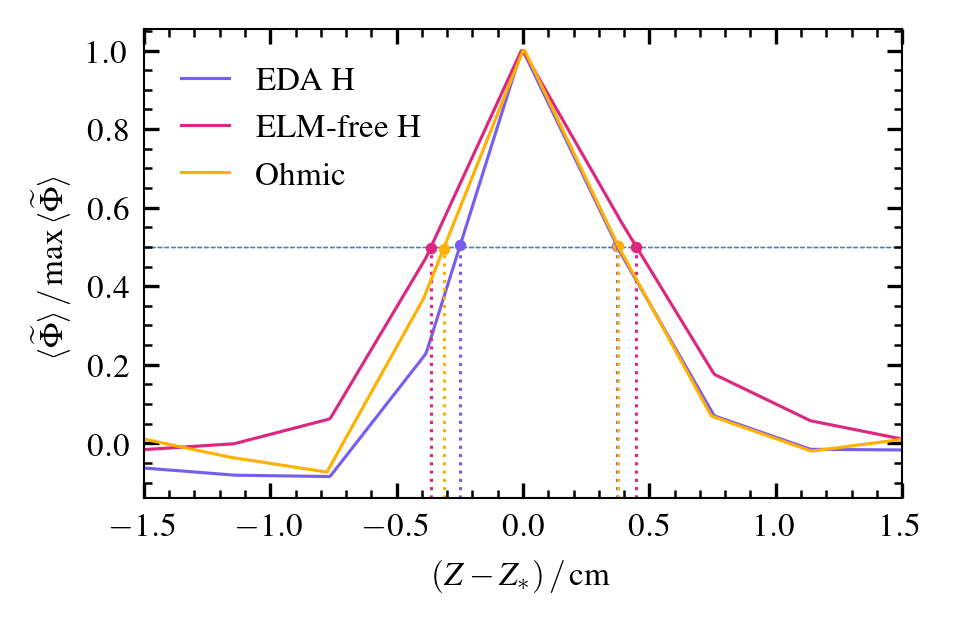

In [9]:
save = True

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')

fig, ax = plt.subplots()

for idx, shot in enumerate(shotlist):
  x_plot = f_Z_xinterp[shot]['f_Z_xinterp']
  y_plot = f_Z_yinterp[shot]['f_Z_yinterp']
  y_plot_norm = y_plot / np.max(y_plot)

  # Find position of the maximum value
  x_norm_value = x_plot[np.where(y_plot == np.max(y_plot))[0][0]]

  # Normalize x-axis to its maximum y value position
  x_plot = x_plot - x_norm_value

  x_scatter_right = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['right_index']]

  # Normalize
  x_scatter_right = x_scatter_right - x_norm_value

  y_scatter_right = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['right_index']]
  y_scatter_right_norm = y_scatter_right / np.max(y_plot)

  x_scatter_left = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['left_index']]

  # Normalize
  x_scatter_left = x_scatter_left - x_norm_value

  y_scatter_left = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['left_index']]
  y_scatter_left_norm = y_scatter_left / np.max(y_plot)

  ax.plot(x_plot, y_plot_norm, label=label_name[idx], color=color_list[idx])
  ax.scatter(x_scatter_right, y_scatter_right_norm, color=color_list[idx])
  ax.scatter(x_scatter_left, y_scatter_left_norm, color=color_list[idx])

  # Plotting the horizontal dotted line
  x_start = Z_coordinates[0][0] - 0.35
  x_left = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['left_index']] - x_norm_value
  x_right = f_Z_xinterp[shot]['f_Z_xinterp'][f_Z_yinterp[shot]['right_index']] - x_norm_value
  y_value = f_Z_yinterp[shot]['f_Z_yinterp'][f_Z_yinterp[shot]['left_index']]
  y_value_norm = y_value / np.max(y_value)

  ax.axhline(y=0.5, linestyle='--', color='steelblue', linewidth=0.3, zorder=0)
  ax.axvline(x=x_left, ymin=0, ymax=y_scatter_left_norm+.03, linestyle=':', color=color_list[idx])
  ax.axvline(x=x_right, ymin=0, ymax=y_scatter_right_norm+.03, linestyle=':', color=color_list[idx])

  print(f'{shotlist[idx]}: {np.round(np.abs(x_left - x_right),2)} cm')

ax.set_xlim(left=-1.5, right=1.5)
ax.set_xlabel(r'$(Z - Z_{\ast}) \,/\, \mathrm{cm} $')
ax.set_ylabel(r"$\langle \widetilde{\Phi} \rangle \,/\, \mathrm{max}\, \langle \widetilde{\Phi} \rangle$")
ax.legend(frameon=False, borderaxespad=0.7, loc='upper left')


foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
if save == True:
    formats = ["pdf", "eps"]
    for fmt in formats:
      filename = f'vertical_blob_size_x_{init_x_pixel}_y_{init_y_pixel}.{fmt}'
      fig.savefig(foldername + filename, format=fmt)


### New calculations

In [2]:
def vertical_blob_size(shot, init_x_pixel, init_y_pixel, interpolation_pnts=500, num_tpts=None):

    # Design target Z coordinates
    zarr = [
        -4.51000,
        -4.14000,
        -3.76000,
        -3.38000,
        -3.00000,
        -2.61000,
        -2.24000,
        -1.86000,
        -1.47000,
        -1.08000,
    ]

    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]

    path = Path("/Users/ahe104/Box/mfe_data/raw_apd_data")
    ds = xr.open_dataset(str(path) + "/" + f"apd_signal_array_{shot}.nc")

    path_dead_pixel = Path("/Users/ahe104/Box/mfe_data/dead_pixels")
    dead_pix = np.load(str(path_dead_pixel) + "/" + f"dead_pixels_shot_{shot}.npz")
    dead_pix_arr = dead_pix[
        "dead_pix_arr"
    ]  # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1, :]  # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9 - y, x]:
                ds["frames"].loc[dict(y=y, x=x)] = np.nan

    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)
    # NB, we use a window radius of 3 to average the time series
    ds = run_mean_ds(ds, 3)

    # ---------------- Get signal of reference pixel and its neighbours ---------------#
    data = get_signal(x=init_x_pixel, y=init_y_pixel, ds=ds)
    time = get_time(x=init_x_pixel, y=init_y_pixel, ds=ds)

    # Vertical neighbour up
    data_up = get_signal(x=init_x_pixel, y=init_y_pixel + 1, ds=ds)

    # Vertical neighbour down
    data_down = get_signal(x=init_x_pixel, y=init_y_pixel - 1, ds=ds)

    # ----------------- Conditional averaging of reference pixel -----------------#

    Svals, s_av, s_var, t_av, peaks, wait = conditional_averaging.cond_av(
        data,
        time,
        2.5,
        # delta=1.4e-4,
        delta=1e-4,
        window=True,
        print_verbose=False,
    )

    # Instead of returning 'peaks_time_base', we sum over waiting times by doing a cumulative sum
    peaks_time_base = np.array([time[0] + list(itertools.accumulate(wait))])[0]

    # List containing all time points of the peak of the reference pixel,
    # for those times it has amplitude larger than above and below (within the time window)
    ref_pixel_peak = []
    ref_pixel_peak_time = []
    ref_pixel_peak_time_idx = []

    rows = 10

    # ----------------------- Vertical blob size function --------------------#

    # Initialize array to store all events for all rows when reference event is largest
    # all_peaks = np.zeros((rows, len(peaks_time_base)))
    all_events_each_row = np.zeros((rows, len(peaks_time_base)))

    # Iterate through all conditional averaged events
    for idx, event in enumerate(peaks_time_base):
        # Time base index of peak point
        peak_time_idx = np.where(np.isin(time, event))[0][0]

        # Center window around the peak and divide by 12 to get only 1/12 of the window
        # (Since there can be so much variation within the conditional averaged window)
        start_idx = int(peak_time_idx - (len(t_av) - 1) / 12)
        end_idx = int(peak_time_idx + (len(t_av) - 1) / 12)

        # Make sure that the first detected event is not at a point of time shorter than the window
        if peak_time_idx < (len(t_av) - 1) / 12:
            start_idx = 0

        # Extract data values within the given time window, for reference pixel and its neighbours up and down
        data_window = data[start_idx:end_idx]
        data_up_window = data_up[start_idx:end_idx]
        data_down_window = data_down[start_idx:end_idx]

        # Check if reference pixel is larger than above and below, within the given time window
        if np.max(data_window) > np.max(data_up_window) and np.max(data_window) > np.max(
            data_down_window
        ):
            ref_pixel_peak.append(peaks[idx])
            ref_pixel_peak_time.append(peaks_time_base[idx])
            ref_pixel_peak_time_idx.append(peak_time_idx)

            # If the reference pixel is larger than the pixel above and below, we extract events at all rows
            for y_pixel in range(rows):
                signal = get_signal(x=init_x_pixel, y=y_pixel, ds=ds)
                # If the pixel is dead, we add nan value to the list
                if len(signal) == 0:
                    all_events_each_row[y_pixel, idx] = np.nan
                # Otherwise, we add the peak value of the signal within the time window
                # (And hopefully we found the peak of the event within this time window:))))
                else:
                    # Now, only time points where the reference pixel is larger than the pixel above and below are added,
                    # otherwise, we have zero values
                    all_events_each_row[y_pixel, idx] = np.max(signal[start_idx:end_idx])

    # Average over all events
    average_vertical_structure = np.nanmean(all_events_each_row, axis=1)

    # Interpolate signal values between each pixel
    zarr_interp = np.linspace(zarr[0], zarr[-1], interpolation_pnts)
    average_vertical_structure_interp = np.interp(
        zarr_interp, zarr, average_vertical_structure
    )

    # Divide by maximum value to normalize
    average_vertical_structure_interp = average_vertical_structure_interp / np.max(
        average_vertical_structure_interp
    )

    # ----------------------------- Full width at half maximum -----------------------------#

    # Find the peak value and its index
    peak_index = np.argmax(average_vertical_structure_interp)
    peak_value = average_vertical_structure_interp[peak_index]
    half_max = peak_value / 2

    # Initialize indices for searching
    left_index = peak_index
    right_index = peak_index

    # Search to the left of the peak
    while left_index > 0 and average_vertical_structure_interp[left_index] > half_max:
        left_index -= 1
    # Adjust the left_index back to the point closest to the half_max
    if left_index > 0:
        left_index = (
            left_index
            if abs(average_vertical_structure_interp[left_index] - half_max)
            < abs(average_vertical_structure_interp[left_index + 1] - half_max)
            else left_index + 1
        )

    # Search to the right of the peak
    while (
        right_index < len(average_vertical_structure_interp) - 1
        and average_vertical_structure_interp[right_index] > half_max
    ):
        right_index += 1
    # Adjust the right_index back to the point closest to the half_max
    if right_index < len(zarr_interp) - 1:
        right_index = (
            right_index
            if abs(average_vertical_structure_interp[right_index] - half_max)
            < abs(average_vertical_structure_interp[right_index - 1] - half_max)
            else right_index - 1
        )

    # Half maximum distance
    distance = np.abs(zarr_interp[right_index] - zarr_interp[left_index])

    return distance, average_vertical_structure_interp, zarr_interp, left_index, right_index

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
# Design target Z coordinates
zarr = [
    -4.51000,
    -4.14000,
    -3.76000,
    -3.38000,
    -3.00000,
    -2.61000,
    -2.24000,
    -1.86000,
    -1.47000,
    -1.08000,
]

In [4]:
params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')

shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

In [5]:
init_x_pixel = 6
init_y_pixel = 4

interpolation_pnts = 500

Shot 1110201016: 1.04 cm
Shot 1110201011: 1.33 cm
Shot 1160616018: 1.08 cm


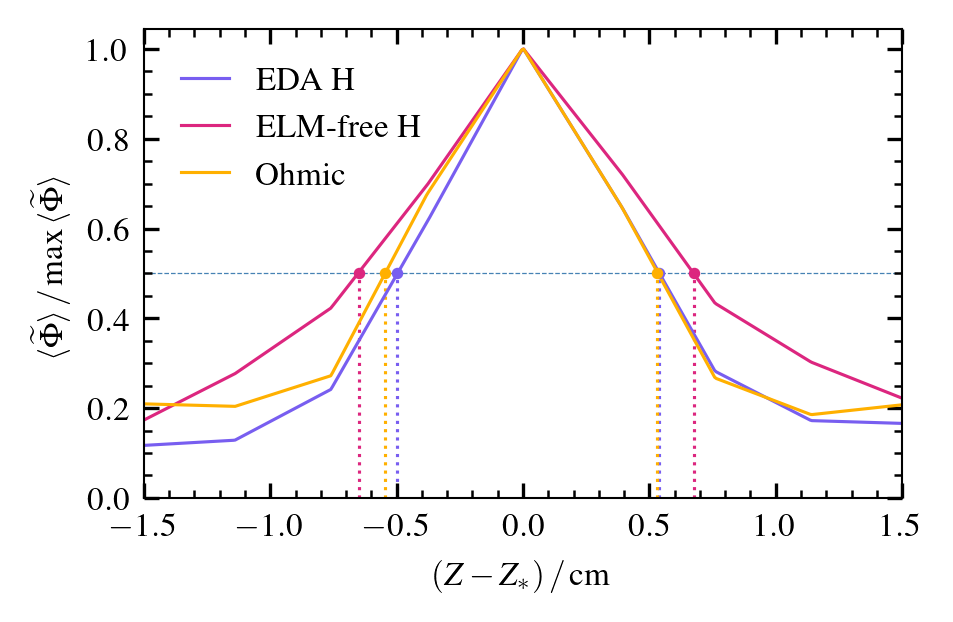

In [19]:
save = True

fig, ax = plt.subplots()

for idx, shot in enumerate(shotlist):
    distance, average_vertical_structure_interp, zarr_interp, left_index, right_index = vertical_blob_size(shot, init_x_pixel, init_y_pixel, interpolation_pnts=interpolation_pnts)

    print(f'Shot {shot}: {np.round(distance,2)} cm')

    if shot == 1160616018:
        # Pixel at Z = -1.08 cm is dead, so we set all values from last pixel up to this point to nan
        # Remove all values between the two upper pixels: Z = -1.47 cm and -1.08 cm
        pixel_index = np.where(zarr_interp == find_nearest(zarr_interp,  -1.47))[0][0]
        length = len(zarr_interp)
        average_vertical_structure_interp[pixel_index:length] = np.nan

    ax.plot(zarr_interp - zarr[init_y_pixel], average_vertical_structure_interp, color=color_list[idx], label=label_name[idx])

    # Vertical left line representing the full width at half maximum
    ax.axvline(
        x=zarr_interp[left_index] - zarr[init_y_pixel], 
        ymin=0, 
        ymax=0.48,
        linestyle=':', 
        color=color_list[idx],
        zorder=1,
    )
    # Scatter point left
    ax.scatter(
        zarr_interp[left_index] - zarr[init_y_pixel], 
        0.5, 
        color=color_list[idx],
        zorder=5,
    )
    # Vertical right line representing the full width at half maximum
    ax.axvline(
        x=zarr_interp[right_index] - zarr[init_y_pixel], 
        ymin=0, 
        ymax=0.48,
        linestyle=':', 
        color=color_list[idx],
        zorder=1,
    )
    # Scatter point right
    ax.scatter(
        zarr_interp[right_index] - zarr[init_y_pixel], 
        0.5, 
        color=color_list[idx],
        zorder=5,
    )


# Horizontal line representing the full width at half maximum
ax.axhline(
    y=0.5, 
    # xmax=0.67, # hard-koding :))))
    linestyle='--', 
    color='steelblue', 
    linewidth=0.3, 
    zorder=0
)

ax.set_ylim(bottom = 0)
ax.set_xlim(left=-1.5, right=1.5)
ax.set_xlabel(r'$(Z - Z_{\ast}) \,/\, \mathrm{cm} $')
ax.set_ylabel(r"$\langle \widetilde{\Phi} \rangle \,/\, \mathrm{max}\, \langle \widetilde{\Phi} \rangle$")
ax.legend(frameon=False, borderaxespad=0.7, loc='upper left')


foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
if save == True:
    formats = ["pdf", "eps"]
    for fmt in formats:
      filename = f'vertical_blob_size_x_{init_x_pixel}_y_{init_y_pixel}_new.{fmt}'
      fig.savefig(foldername + filename, format=fmt)

In [20]:
print(1.33-1.04)

0.29000000000000004


In [21]:
3.9e-3

0.0039